### Groupe :
- AVENA Clément
- BRUNET Ronan
- KHADRAOUI Sabri
- MARTINEZ Romain

# Propagation d’opinion dans un réseau social
## Vision déterministe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from IPython.display import HTML

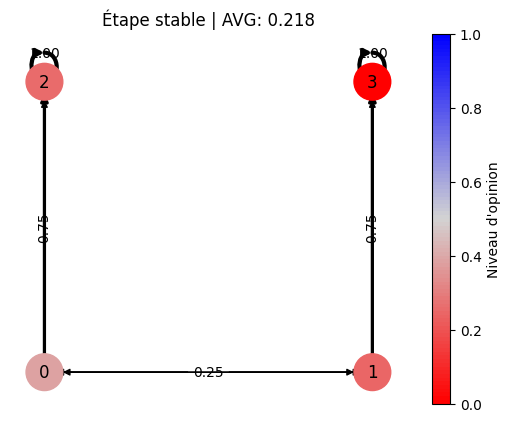

In [19]:
reseau1_Influence = np.array([[0, 0.25, 0.75, 0],
                              [0.25, 0, 0, 0.75],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
reseau1_Opinion = [1.0, 0.75, 0.25, 0] #L'indice correpond au noeud dans le graphe
reseau1_Pos = {
    0: (0, 0),    # Position du nœud 0
    1: (1, 0),    # Position du nœud 1
    2: (0, 1),   # Position du nœud 2
    3: (1, 1)     # Position du nœud 3
}

#Traduction pour affichage car DiGraph n'accepte que des matrices composées de 0 ou de 1
def tradReseauAffichage(reseau: np.array):
    tradReseau = reseau.copy()
    for noeud in tradReseau:
        for influence in noeud:
            if influence != 0: #Si il y a une influence alors il y a une connection
                influence = 1
    return tradReseau

#Affichage graphe
def generateColorGradientMap(opinion):
    colors = ['red', 'lightgrey', 'blue']
    n_bins = 100 
    cm = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
    node_colors = [cm(value) for value in opinion] 
    return node_colors, cm 

def generateGraph(reseau_Influence, reseau_Opinion, desiredPos, ax):
    G = nx.DiGraph()
    n = reseau_Influence.shape[0]
    for i in range(len(reseau_Opinion)):
        G.add_node(i, value=reseau_Opinion[i])
    for i in range(n):
        for j in range(n):
            if reseau_Influence[i, j] > 0:  # Si il y a une connexion
                G.add_edge(i, j, weight=reseau_Influence[i, j])  # Ajouter les arcs avec le poids
    edges = G.edges(data=True)  # Récupération des arcs avec poids
    weights = [edge[2]['weight'] for edge in edges]  # Création d'une liste contenant que les poids

    # Normalisation des poids pour l'épaisseur des arcs
    min_weight = min(weights)
    max_weight = max(weights)
    normalized_weights = [(weight - min_weight) / (max_weight - min_weight) * 2 + 1 for weight in weights]

    # Dessin des nœuds et arcs
    node_colors, _ = generateColorGradientMap(reseau_Opinion)
    nx.draw(G, pos=desiredPos, node_color=node_colors, with_labels=True, ax=ax, node_size=700)
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in edges} #Valeur des arcs (donc les poids d'influence)
    nx.draw_networkx_edge_labels(G, desiredPos, edge_labels=edge_labels, ax=ax)
    nx.draw_networkx_edges(G, pos=desiredPos, edgelist=edges, width=normalized_weights, ax=ax)

#Vérifications de la matrice avant de pourvoir faire des calculs dessus
def verifMatConforme(mat, opinions):
    if len(mat) != len(opinions):
        raise Exception("La matrice n'as pas assez de points pour correspondre au nombre de noeud des opinions")
    for opinion in opinions:
        if opinion > 1 or opinion < 0:
            raise Exception(f"La liste d'opinion n'est pas valide. Valeur suppérieur à 1 ou inférieure à 0. Opinion: {opinion}")
    for i, noeud in enumerate(mat):
        if len(noeud) != len(opinions):
            raise Exception(f"La ligne {i} de la matrice n'as pas assez de points pour correspondre au nombre de noeud des opinions. {len(noeud)} contre {len(opinions)}")
        sommeInfluence = 0
        for influence in noeud:
            sommeInfluence += influence
        if sommeInfluence != 1:
            raise Exception(f"La somme des influences de la matrice n'est pas égale à 1. Ligne: {i}, Somme: {sommeInfluence}")

#Mise à jour des opinions
def newOpinion(x:int, mat, opinions):
    newOpinionValue = 0
    for y in range(len(opinions)):
        newOpinionValue += mat[x][y] * opinions[y]
    return newOpinionValue

def calcNextOpinionStep(matInfluence, listOpinions):
    verifMatConforme(matInfluence, listOpinions)
    nextListOpinions = []
    for i in range(len(listOpinions)):
        nextListOpinions.append(newOpinion(i, matInfluence, listOpinions))
    return nextListOpinions

def newOpinionProba(x:int, mat, opinions):
    influenceNode = {}
    for y in range( len(mat[x]) ):
        influenceNode[y] = mat[x][y]
    influenceNodeWithoutZeroSort = {k: v for k, v in influenceNode.items() if v != 0.0}
    proba = random.random() # Valeur entre 0 et 1
    previous = 0
    for k, v in influenceNodeWithoutZeroSort.items():
        if previous <= proba and proba <= previous + v:
            return opinions[k]
        previous += v

def calculateEsperance(Opinions, influenceMatrix, desiredPos):
    markovMatrix = createMarkovMat(influenceMatrix)
    esp = np.dot(markovMatrix, Opinions)
    fig, ax = plt.subplots()
    _, cm = generateColorGradientMap(esp)
    sm = ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=0, vmax=1))
    generateGraph(influenceMatrix, esp, desiredPos, ax)
    ax.set_title(f'Étape stable | AVG: {round(sum(esp) / len(esp), 3)}')
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Niveau d\'opinion')
    return

def createMarkovMat(influenceMatrix, nbIteration=100):
    matMarkov = [[0]*len(influenceMatrix[0])]*len(influenceMatrix) 
    for l in range(len(influenceMatrix)): #Pour chaque ligne (noeud)
        currentProbaList = [0]*len(influenceMatrix)
        influenceNode = {}
        for y in range( len(influenceMatrix[l]) ):
            influenceNode[influenceMatrix[l][y]] = y
        influenceNodeWithoutZeroSort = {k: v for k, v in influenceNode.items() if k != 0.0}
        for m in range(nbIteration): #Je fais 100x
            proba = random.random() # Valeur entre 0 et 1
            previous = 0
            for v, k in influenceNodeWithoutZeroSort.items(): #Pour chaque noeud qui ont une influence    
                if previous <= proba and proba <= previous + v: #Quand je trouve le chemin a prendre
                    currentProbaList[k] += 1 # Alors je l'incrémente d'un passage
                    break;
                else:
                    previous += v #Sinon je met a jour la prochaine borne pour la comparaison
        matMarkov[l] = [prob/nbIteration for prob in currentProbaList] #Une fois que j'ai calculé le nombre de passage j'affecte la liste de proba
    return matMarkov #Je renvoie la matrice de proba

def calcNextOpinionStepProba(influenceMatrix, listOpinions):
    # verifMatConforme(influenceMatrix, listOpinions)
    nextListOpinions = []
    for i in range(len(listOpinions)):
        nextListOpinions.append(newOpinionProba(i, influenceMatrix, listOpinions))
    return nextListOpinions

def createAnimation(nbGeneration, initialOpinions, influenceMatrix, positions, isProbabilistMode=False, fps=1):
    opinions_list = [initialOpinions]
    # matProbaMarkov = createMarkovMat(initialOpinions, influenceMatrix)
    for _ in range(nbGeneration):
        initialOpinions = calcNextOpinionStepProba(influenceMatrix, initialOpinions) if isProbabilistMode else calcNextOpinionStep(influenceMatrix, initialOpinions)
        opinions_list.append(initialOpinions)
    fig, ax = plt.subplots()

    _, cm = generateColorGradientMap(opinions_list[0])
    sm = ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=0, vmax=1))
    
    def update(frame):
        ax.clear()
        generateGraph(influenceMatrix, opinions_list[frame], positions, ax)
        ax.set_title(f'Étape {frame} | AVG: {round(sum(opinions_list[frame]) / len(opinions_list[frame]), 3)}')

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Niveau d\'opinion')
    
    ani = FuncAnimation(fig, update, frames=len(opinions_list), interval=1000, repeat=False)
    plt.close(fig)  # Close the figure to avoid display before returning

    ani.save('my_animation.gif', writer='pillow', fps=fps)
    
    return ani

def createCombinedAnimation(nbGeneration, opinions1, influenceMatrix1, positions1, opinions2, influenceMatrix2, positions2, is1ProbabilistMode=False, is2ProbabilistMode=False):
    # Prepare data for both animations
    opinions_list1 = [opinions1]
    opinions_list2 = [opinions2]
    # matProbaMarkov1 = createMarkovMat(opinions1, influenceMatrix1)
    # matProbaMarkov2 = createMarkovMat(opinions2, influenceMatrix2)
    
    for _ in range(nbGeneration):
        opinions1 = calcNextOpinionStepProba(influenceMatrix1, opinions1) if is1ProbabilistMode else calcNextOpinionStep(influenceMatrix1, opinions1)
        opinions2 = calcNextOpinionStepProba(influenceMatrix2, opinions2) if is2ProbabilistMode else calcNextOpinionStep(influenceMatrix2, opinions2)
        opinions_list1.append(opinions1)
        opinions_list2.append(opinions2)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    
    # Generate color maps for both animations
    _, cm1 = generateColorGradientMap(opinions_list1[0])
    _, cm2 = generateColorGradientMap(opinions_list2[0])
    
    sm1 = ScalarMappable(cmap=cm1, norm=plt.Normalize(vmin=0, vmax=1))
    sm2 = ScalarMappable(cmap=cm2, norm=plt.Normalize(vmin=0, vmax=1))
    
    def update(frame):
        # Clear both axes
        axes[0].clear()
        axes[1].clear()
        
        # Update first graph
        generateGraph(influenceMatrix1, opinions_list1[frame], positions1, axes[0])
        avg_opinion1 = round(sum(opinions_list1[frame]) / len(opinions_list1[frame]), 3)
        axes[0].set_title(f'{"Déterministe" if is1ProbabilistMode else "Probabiliste"} | Étape {frame} | AVG: {avg_opinion1}')
        
        # Update second graph
        generateGraph(influenceMatrix2, opinions_list2[frame], positions2, axes[1])
        avg_opinion2 = round(sum(opinions_list2[frame]) / len(opinions_list2[frame]), 3)
        axes[1].set_title(f'{"Déterministe" if is1ProbabilistMode else "Probabiliste"} | Étape {frame} | AVG: {avg_opinion2}')
    
    # Add colorbars for both subplots
    cbar1 = fig.colorbar(sm1, ax=axes[0], orientation='vertical')
    cbar1.set_label(f'Niveau d\'opinion ({"Déterministe" if is1ProbabilistMode else "Probabiliste"})')
    
    cbar2 = fig.colorbar(sm2, ax=axes[1], orientation='vertical')
    cbar2.set_label(f'Niveau d\'opinion ({"Déterministe" if is1ProbabilistMode else "Probabiliste"})')
    
    # Create the combined animation
    ani = FuncAnimation(fig, update, frames=len(opinions_list1), interval=1000, repeat=False)
    plt.close(fig)  # Prevent premature display
    
    return ani

HTML(createAnimation(4, reseau1_Opinion, reseau1_Influence, reseau1_Pos).to_jshtml())

In [3]:
reseau2_Influence = np.array([[0, 0.25, 0.75, 0, 0],
                              [0.25, 0, 0, 0.75, 0],
                              [0, 0, 1, 0, 0],
                              [0, 0, 0, 1, 0],
                              [0.25, 0.25, 0.25, 0.25, 0]])
reseau2_Opinion = [1.0, 0.75, 0.25, 1.0, 1.0] #L'indice correpond au noeud dans le graphe
reseau2_Pos = {
    0: (0, 0),    # Position du nœud 0
    1: (2, 0),    # Position du nœud 1
    2: (0, 2),    # Position du nœud 2
    3: (2, 2),    # Position du nœud 3
    4: (1, 1)     # Position du nœud 3
}

HTML(createAnimation(4, reseau2_Opinion, reseau2_Influence, reseau2_Pos).to_jshtml())

### Cas 3 : Un groupe

In [4]:
reseau3_Influence = np.array([[0, 0.33, 0, 0, 0, 0, 0, 0.33, 0.34],
                              [0.33, 0, 0.33, 0, 0, 0, 0, 0, 0.34],
                              [0, 0.33, 0, 0.33, 0, 0, 0, 0, 0.34],
                              [0, 0, 0.33, 0, 0.33, 0, 0, 0, 0.34],
                              [0, 0, 0, 0.33, 0, 0.33, 0, 0, 0.34],
                              [0, 0, 0, 0, 0.33, 0, 0.33, 0, 0.34],
                              [0, 0, 0, 0, 0, 0.33, 0, 0.33, 0.34],
                              [0.33, 0, 0, 0, 0, 0, 0.33, 0, 0.34],
                              [0.2, 0, 0, 0, 0, 0, 0, 0, 0.8]])
reseau3_Opinion = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2] #L'indice correpond au noeud dans le graphe
reseau3_Pos = {
    0: (0, 1),    # Position du nœud 0
    1: (0, 3),    # Position du nœud 1
    2: (1, 4),    # Position du nœud 2la
    3: (3, 4),    # Position du nœud 3
    4: (4, 3),    # Position du nœud 3
    5: (4, 1),
    6: (3, 0),
    7: (1, 0),
    8: (2, 2)
}

HTML(createAnimation(4, reseau3_Opinion, reseau3_Influence, reseau3_Pos).to_jshtml())

#### Idée
Observer le changement d'opinion lorsque un groupe entier prend en compte l'opinion d'une personne qui de son coté base la sienne sur une seule personne et mais conserve a 80% son opinion de base

#### Hypothèse
On espère voir le point 8 prendre comme opinion quelque chose de plus proche de 1 que de son etat initial puis comme il influence tout le monde et qu'ils deviendront proche de 0 alors 8 récupèrera une valeur proche de 0

#### Observation
Le noeud 8 se rapproche effectivement vers une opinion plus proche de 1, cependant contrairement à ce que l'on s'attendait, l'ensemble des opinions se sont lissée pour s'approcher d'une opinion d'environ 0.4

### Cas 4 : Le groupe 2e édition

In [5]:
reseau4_Influence = np.array([[0, 0.33, 0, 0, 0, 0, 0, 0.33, 0.34],
                              [0.33, 0, 0.33, 0, 0, 0, 0, 0, 0.34],
                              [0, 0.33, 0, 0.33, 0, 0, 0, 0, 0.34],
                              [0, 0, 0.33, 0, 0.33, 0, 0, 0, 0.34],
                              [0, 0, 0, 0.33, 0, 0.33, 0, 0, 0.34],
                              [0, 0, 0, 0, 0.33, 0, 0.33, 0, 0.34],
                              [0, 0, 0, 0, 0, 0.33, 0, 0.33, 0.34],
                              [0.33, 0, 0, 0, 0, 0, 0.33, 0, 0.34],
                              [0.5, 0, 0, 0, 0, 0, 0, 0, 0.5]])
reseau4_Opinion = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2] #L'indice correpond au noeud dans le graphe
reseau4_Pos = {
    0: (0, 1),    # Position du nœud 0
    1: (0, 3),    # Position du nœud 1
    2: (1, 4),    # Position du nœud 2
    3: (3, 4),    # Position du nœud 3
    4: (4, 3),    # Position du nœud 3
    5: (4, 1),
    6: (3, 0),
    7: (1, 0),
    8: (2, 2)
}

HTML(createAnimation(4, reseau4_Opinion, reseau4_Influence, reseau4_Pos).to_jshtml())

#### Idée
Observer le changement d'opinion lorsque un groupe entier prend en compte l'opinion d'une personne qui de son coté base la sienne sur une seule personne à 50% et conserve a 50% son opinion de base

#### Hypothèse
Nous pensons que lors de la première itération le noeud 0 va voir son opinion drastiquement changer vers une opinion neutre, puis qu'en définitive le sytème sera neutre à tendance vers l'opinion 0

#### Observation
Lors du premier tour le noeud 0 a effectivement tourné sur un opinion d'environ 0.3 avant de passer sur une opinion de 0.6 au second tour. Lors de ce second tour le système a une opinion neutre bleutée puis une fois stabilisé, le système a une opinion neutr bleutée sauf pour le nouefd 7 et 5 qui sont neutres

### Cas 5 : Un réel groupe d'amis

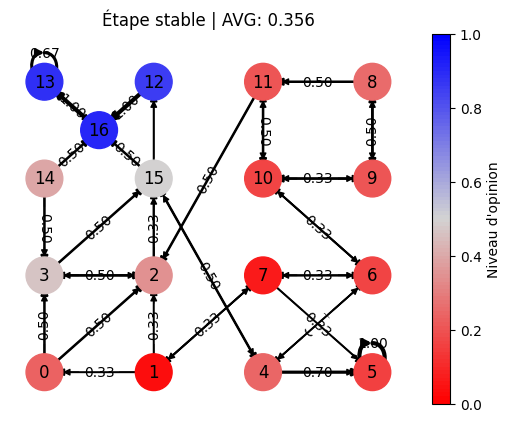

In [21]:
reseau5_Influence = np.array([[0, 0, 1/2, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [1/3, 0, 1/3, 0, 0, 0, 0, 1/3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 1/3, 0, 0, 0, 0, 0, 0, 0, 0, 1/3, 0, 0, 1/3, 0],
                              [0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0],
                              [0, 0, 0, 0, 0, 0.7, 0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0.15, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 1/3, 0, 0, 1/3, 0, 0, 1/3, 0, 0, 0, 0, 0, 0],
                              [0, 1/3, 0, 0, 0, 1/3, 1/3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 1/2, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 1/2, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1/3, 0, 0, 1/3, 0, 1/3, 0, 0, 0, 0, 0],
                              [0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2/3, 0, 0, 1/3],
                              [0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2],
                              [0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])
reseau5_Opinion = [0.7, 0.35, 0.6, 0.45, 0.3, 0.15, 0.2, 0.1, 0.55, 0.45, 0.4, 0.6, 1.0, 0.9, 0.8, 0.95, 0.85] #L'indice correpond au noeud dans le graphe
reseau5_Pos = {
    0: (0, -1),    # Position du nœud 0
    1: (2, -1),    # Position du nœud 1
    2: (2, 1),    # Position du nœud 2
    3: (0, 1),    # Position du nœud 3
    4: (4, -1),    # Position du nœud 3
    5: (6, -1),
    6: (6, 1),
    7: (4, 1),
    8: (6, 5),
    9: (6, 3),
    10: (4, 3),
    11: (4, 5),
    12: (2, 5),
    13: (0, 5),
    14: (0, 3),
    15: (2, 3),
    16: (1, 4),
}

#HTML(createAnimation(30, reseau5_Opinion, reseau5_Influence, reseau5_Pos, True, fps=8).to_jshtml())
calculateEsperance(reseau5_Opinion, reseau5_Influence, reseau5_Pos)

#### Idée
L'idée était de voir comment une opinion pouvait se propager entre les groupes d'amis par le biai d'amis de connection entre deux groupe et observer les changments qui opèrent à l'intérieur des dits groupes

#### Hypothèse


#### Observation


### Cas 6 : Arbre

In [7]:
reseau6_Influence = np.array([[0, 1/2, 1/2, 0, 0, 0, 0, 0, 0],
                              [0, 0, 1/3, 0, 1/3, 1/3, 0, 0, 0],
                              [0, 1/3, 0, 0, 0, 0, 1/3, 1/3, 0],
                              [1/3, 1/3, 0, 0, 1/3, 0, 0, 0, 0],
                              [0, 0.6, 0, 0.2, 0, 0.2, 0, 0, 0],
                              [0, 0, 0, 0, 0.2, 0.8, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0.8, 0.2, 0],
                              [0, 0, 0.6, 0, 0, 0, 0.2, 0, 0.2],
                              [1/3, 0, 1/3, 0, 0, 0, 0, 1/3, 0]])
reseau6_Opinion = [0.5, 0.75, 0.25, 0, 1.0, 0, 1.0, 0, 1.0] #L'indice correpond au noeud dans le graphe
reseau6_Pos = {
    0: (3, 2),    # Position du nœud 0
    1: (1, 1),    # Position du nœud 1
    2: (5, 1),    # Position du nœud 2
    3: (0, 0),    # Position du nœud 3
    4: (1, 0),    # Position du nœud 3
    5: (2, 0),
    6: (4, 0),
    7: (5, 0),
    8: (6, 0),
}

HTML(createAnimation(10, reseau6_Opinion, reseau6_Influence, reseau6_Pos).to_jshtml())

#### Idée
L'idée était de voir comment une opinion pouvait se propager dans une relation de type arborescente
#### Hypothèse

#### Observation


### Cas 7 : Propagation d'opinion

In [8]:
reseau6_Influence = np.array([[0, 1/2, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [1/4, 0, 0, 1/4, 1/4, 1/4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [1/4, 0, 0, 0, 0, 0, 1/4, 1/4, 1/4, 0, 0, 0, 0, 0, 0],
                              [0, 1/3, 0, 0, 0, 0, 0, 0, 0, 1/3, 1/3, 0, 0, 0, 0],
                              [0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0],
                              [0, 1/3, 0, 0, 0, 0, 0, 0, 0, 0, 1/3, 1/3, 0, 0, 0],
                              [0, 0, 1/3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/3, 1/3, 0],
                              [0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0],
                              [0, 0, 1/3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/3, 1/3],
                              [0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0],
                              [0, 0, 0, 1/5, 1/5, 1/5, 0, 0, 0, 1/5, 0, 1/5, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 1/2, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 1/2, 0],
                              [0, 0, 0, 0, 0, 0, 1/5, 1/5, 1/5, 0, 0, 0, 1/5, 0, 1/5],
                              [0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 1/2, 0]])
reseau6_Opinion = [0.5, 0.65, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5] #L'indice correpond au noeud dans le graphe
reseau6_Pos = {
    0: (3, 3),    # Position du nœud 0
    1: (1, 2),    # Position du nœud 1
    2: (5, 2),    # Position du nœud 2
    3: (0, 1),    # Position du nœud 3
    4: (1, 1),    # Position du nœud 3
    5: (2, 1),
    6: (4, 1),
    7: (5, 1),
    8: (6, 1),
    9: (0, 0),
    10: (1, 0),
    11: (2, 0),
    12: (4, 0),
    13: (5, 0),
    14: (6, 0),
}

HTML(createAnimation(50, reseau6_Opinion, reseau6_Influence, reseau6_Pos, fps=20).to_jshtml())

## Vision déterministe

In [9]:
HTML(createCombinedAnimation(10, reseau6_Opinion, reseau6_Influence, reseau6_Pos, reseau6_Opinion, reseau6_Influence, reseau6_Pos, is2ProbabilistMode=True).to_jshtml())